# Neural network for classification of contaminants with MAT

## 1. Formulate/outline the problem: classification

Simple neural network for classification of the contaminants using MAT transcriptomes


In [43]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from tensorflow import keras

In [44]:
file_name = "gene_counts_NN_training.csv"

In [45]:
data = pd.read_csv(file_name)

## 2. Identify inputs and outputs

In [46]:
data.head()

,sample,HUNK,KLHL8,ZNF576,UGT1A5,FCF1,SLC2A7,FABP12,TAF12,GLRX,...,ASIC2,TSN,EVA1A,NFATC1,PORCN,GALNT17,DEPDC4,REL,RPL23,AHSP
0,R848,1.0,282.0,84.0,0.0,500.0,0.0,0.0,124.0,281.0,...,0.0,722.0,0.0,688.0,45.0,0.0,0.0,12160.0,6042.0,1.0
1,CRX-527,0.0,35.0,5.0,0.0,63.0,0.0,0.0,14.0,20.0,...,0.0,55.0,0.0,94.0,2.0,0.0,0.0,484.0,746.0,0.0
2,CL-307,3.0,152.0,41.0,0.0,293.0,0.0,0.0,88.0,154.0,...,0.0,462.0,0.0,495.0,38.0,0.0,0.0,4353.0,3391.0,2.0
3,Pam3,0.0,55.0,28.0,0.0,152.0,0.0,0.0,32.0,60.0,...,0.0,204.0,0.0,234.0,10.0,0.0,0.0,1350.0,2014.0,1.0
4,Pam3,0.0,115.0,32.0,0.0,235.0,0.0,0.0,68.0,71.0,...,0.0,375.0,0.0,409.0,23.0,0.0,0.0,3349.0,2760.0,0.0


## 3. Prepare data

In [47]:
target = pd.get_dummies(data["sample"], dtype=int)
target.head()

,CL-307,CRX-527,Fla-PA,IMDM,LPS,LTA,PGN,Pam3,R848
0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0


In [48]:
data_features = data.drop(columns=["sample"])

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_features, target, test_size=0.2, random_state=0, shuffle=True, stratify=target
)

In [50]:
X_train.shape, X_test.shape

((32, 19992), (9, 19992))

In [51]:
y_train.shape, y_test.shape

((32, 9), (9, 9))

In [52]:
import numpy as np


def to_normalize_DESeq2_style(data):
    # Ensure all values are non-negative
    data = data.applymap(lambda x: max(x, 0))

    # Take the log
    log_data = np.log1p(data)

    # Calculate the pseudo-reference sample for each gene
    log_data["pseudo_reference"] = log_data.mean(axis=1)

    # Filter out genes with -Inf as their average
    filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

    # Subtract the gene pseudo-references from log counts
    ratio_data = filtered_log_data.iloc[:, :-1].sub(
        filtered_log_data["pseudo_reference"], axis=0
    )

    # Find the median of the ratios for each sample
    sample_medians = ratio_data.median(axis=0)

    # Convert medians to scaling factors
    scaling_factors = np.exp(sample_medians)

    # Divide the original counts by the scaling factors
    manually_normalized = data.div(scaling_factors)

    return manually_normalized


X_train = to_normalize_DESeq2_style(X_train)

X_test = to_normalize_DESeq2_style(X_test)

## 4. Build an architecture from scratch or choose a pretrained model

In [101]:
keras.backend.clear_session()
keras.utils.set_random_seed(2)

In [110]:
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=2)

In [249]:
# create our model
def create_nn():
    inputs = keras.Input(shape=X_train.shape[1])
    x = keras.layers.UnitNormalization()(inputs)
    x = keras.layers.Dense(35, activation="relu")(x)
    x = keras.layers.Dense(20, activation="relu")(x)
    outputs = keras.layers.Dense(9, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="small_NN")
    return model


model = create_nn()
model.summary()

Model: "small_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 19992)]           0         
                                                                 
 unit_normalization_35 (Unit  (None, 19992)            0         
 Normalization)                                                  
                                                                 
 dense_111 (Dense)           (None, 35)                699755    
                                                                 
 dense_112 (Dense)           (None, 20)                720       
                                                                 
 dense_113 (Dense)           (None, 9)                 189       
                                                                 
Total params: 700,664
Trainable params: 700,664
Non-trainable params: 0
____________________________________________________

## 5. Choose a loss function and optimizer

In [250]:
def compile_model(model):
    model.compile(
        optimizer="adam",
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )


compile_model(model)

## 6. Train model

In [251]:
history = model.fit(
    X_train, y_train, epochs=200, callbacks=[callback], validation_data=(X_test, y_test)
)

Epoch 1/200


/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 1s 560ms/step - loss: 2.1974 - accuracy: 0.1250 - val_loss: 2.1956 - val_accuracy: 0.1111
Epoch 2/200
1/1 [==============================] - 0s 35ms/step - loss: 2.1889 - accuracy: 0.1250 - val_loss: 2.1934 - val_accuracy: 0.2222
Epoch 3/200
1/1 [==============================] - 0s 39ms/step - loss: 2.1748 - accuracy: 0.2500 - val_loss: 2.1890 - val_accuracy: 0.2222
Epoch 4/200
1/1 [==============================] - 0s 37ms/step - loss: 2.1571 - accuracy: 0.2500 - val_loss: 2.1851 - val_accuracy: 0.2222
Epoch 5/200
1/1 [==============================] - ETA: 0s - loss: 2.1411 - accuracy: 0.2500

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 0s 37ms/step - loss: 2.1411 - accuracy: 0.2500 - val_loss: 2.1775 - val_accuracy: 0.3333
Epoch 6/200
1/1 [==============================] - 0s 38ms/step - loss: 2.1224 - accuracy: 0.4688 - val_loss: 2.1704 - val_accuracy: 0.2222
Epoch 7/200
1/1 [==============================] - 0s 37ms/step - loss: 2.1059 - accuracy: 0.5000 - val_loss: 2.1638 - val_accuracy: 0.2222
Epoch 8/200
1/1 [==============================] - 0s 40ms/step - loss: 2.0868 - accuracy: 0.5000 - val_loss: 2.1587 - val_accuracy: 0.3333
Epoch 9/200
1/1 [==============================] - 0s 39ms/step - loss: 2.0676 - accuracy: 0.5000 - val_loss: 2.1532 - val_accuracy: 0.3333
Epoch 10/200
1/1 [==============================] - 0s 37ms/step - loss: 2.0481 - accuracy: 0.5000 - val_loss: 2.1476 - val_accuracy: 0.3333
Epoch 11/200
1/1 [==============================] - 0s 39ms/step - loss: 2.0292 - accuracy: 0.5000 - val_loss: 2.1415 - val_accuracy: 0.3333
Epoch 12/200
1/1 [============

## 8. Measure performance

In [252]:
def plot_history(history, metrics):
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

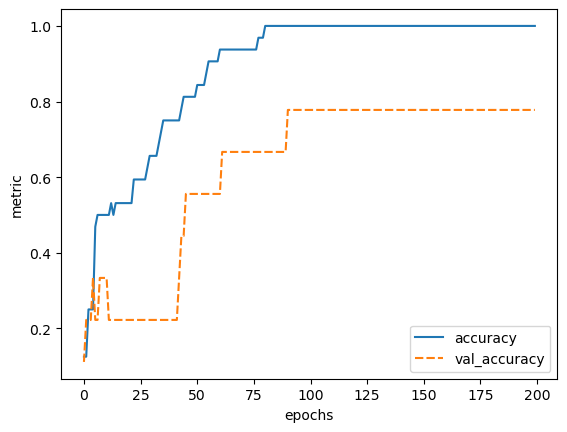

In [253]:
plot_history(history, ["accuracy", "val_accuracy"])

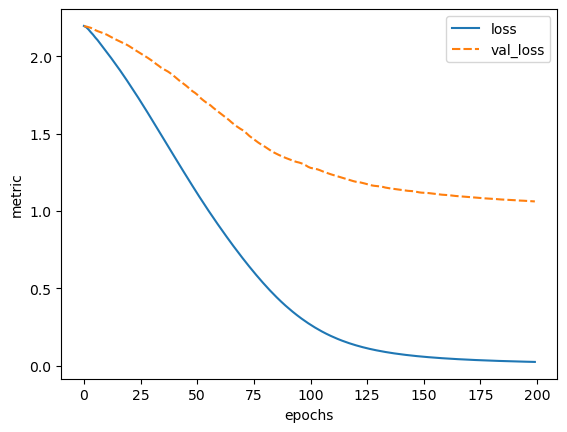

In [254]:
plot_history(history, ["loss", "val_loss"])